# Welcome to NameWeave
#### A Neural Network Approach To Predict Indian Names based on a dataset I crawled from the Internet.

#### What are we trying to achieve?

##### We are trying to generate names based on training names.

**For example**,

We have a list of names:
1. Adesh
2. Aadhan
3. Aadhar
4. Aadhav

We are trying to generate a name like:
- Aadharsh

**Note:** This is a character level language model where we try to predict the next character based on previous character(s)

# Downloading Dependencies

We will need the following dependencies:
- torch (PyTorch) - PyTorch is a massive library for machine learning computation and algorithms in an all-in-one package.
- numpy - For array manupulation
- pandas - Pandas is a library for manipulating the data in tabular format
- matplotlib - For visualizing the data

In [1]:
!pip install torch
!pip install numpy
!pip install pandas
!pip install matplotlib

# Importing Libraries

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\avhis\AppData\Local\Temp\ipykernel_2084\3422025525.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Loading Dataset

Let's now look at the dataset using Pandas library and see how our dataset looks like...

In [3]:
pd.read_csv("Datasets/Indian_Names.txt")

,Aaban
0,Aabharan
1,Aabhas
2,Aabhat
3,Aabheer
4,Abheer
...,...
53976,Zumathy
53977,Zurika
53978,Zuruthi
53979,Zuruthika


Looks like we have a text file with roughly 54000 names, separated by lines (not commas) \
We can now safely read all the names into our memory in form of native datatype variables.

In [4]:
words = open("Datasets/Indian_Names.txt").read().splitlines()

In [5]:
len(words)

53982

Looks like we were correctly able to load the names in a list called **'words'**

Let's make these words lower cased to decrease complexity.

In [6]:
words = [word.lower() for word in words]

# Approach

Before we completely dive into a complex neural network, \
Let's first make a traditional bigram approach, 
1. which takes a name from all the names,
2. splits the name into individual characters
3. compiles a Bigram of the name
4. trains a traditional model
5. tries to predict new names

Now **what is a Bigram** you ask?

Suppose we take a name -> ADESH
We will try to take each character and try to predict the next one.
For example,
- D comes next of A
- E comes next of D
- and so on...

Let's visualize it to have a more easier understanding: \
![Bigram](ExplanationMedia/Images/NameWeaveBigram.png)

In order to predict these bigrams, we will make a look-up table...
Which will constist of all the possible Bigrams through the 26 letters of the english alphabets...

Note: \
We also would have to consider which character should come before a character starts and also what comes after the character ends \
To mark a proper start and end point of the word.

Let's visualize this: \
![Bigram](ExplanationMedia/Images/NameWeaveBigramStartEnd.png)

**What to do next with these bigrams you ask?**

We will try to create a probability distribution where we will be able to \
predict the next character based on their distributions.

# Preparing Bigrams

Now before we start preparing our bigrams, we would be needing two helper look-up tables/dictionaries:

- stoi -> Maps the string character to it's index
- itos -> Maps the index to their respective string characters

In [7]:
characters = sorted(list(set(''.join(words)))) # Gives us all the characters in the english alphabet, hopefully our dataset has all of them
stoi = {s:i for i,s in enumerate(characters)} # Enumerate returns the tuples of number and string, which can then be mapped to string:index
itos = {i:s for s,i in stoi.items()} # After we have the string:index mapping, we can easily iterate over their items to map index:string
print("Characters:",characters,"Length:",len(characters))
print("STOI:",stoi)
print("ITOS",itos)

Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] Length: 26
STOI: {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}
ITOS {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


In [8]:
# Remember we need our starting and ending tokens as well in these mappings,
characters = sorted(list(set(''.join(words)))) # Gives us all the characters in the english alphabet, hopefully our dataset has all of them
stoi = {s:i for i,s in enumerate(characters)} # Enumerate returns the tuples of number and string, which can then be mapped to string:index
# We manually add these tokens for convenience
stoi['<S>'] = 26
stoi['<E>'] = 27
itos = {i:s for s,i in stoi.items()} # After we have the string:index mapping, we can easily iterate over their items to map index:string
print("Characters:",characters)
print("STOI:",stoi)
print("ITOS",itos)

Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
STOI: {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '<S>': 26, '<E>': 27}
ITOS {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: '<S>', 27: '<E>'}


Let's now prepare our bigrams for each names...

In [18]:
for word in words[:5]:
    print("Name:",word)
    for character1, character2 in zip(word, word[1:]):
        print(character1,character2)

Name: aaban
a a
a b
b a
a n
Name: aabharan
a a
a b
b h
h a
a r
r a
a n
Name: aabhas
a a
a b
b h
h a
a s
Name: aabhat
a a
a b
b h
h a
a t
Name: aabheer
a a
a b
b h
h e
e e
e r


Seems to be in the right direction, but we still need the start and end tokens

In [21]:
for word in words[:5]:
    print("Name:",word)
    word = ['<S>'] + list(word) + ['<E>']
    for character1, character2 in zip(word, word[1:]):
        print(character1,character2)

Name: aaban
<S> a
a a
a b
b a
a n
n <E>
Name: aabharan
<S> a
a a
a b
b h
h a
a r
r a
a n
n <E>
Name: aabhas
<S> a
a a
a b
b h
h a
a s
s <E>
Name: aabhat
<S> a
a a
a b
b h
h a
a t
t <E>
Name: aabheer
<S> a
a a
a b
b h
h e
e e
e r
r <E>


Let's now create a frequency count for each bigram

In [23]:
bigramFrequency = {}
for word in words[:5]:
    print("Name:",word)
    word = ['<S>'] + list(word) + ['<E>']
    for character1, character2 in zip(word, word[1:]):
        bigram = (character1, character2)
        bigramFrequency[bigram] = bigramFrequency.get(bigram, 0) + 1
print(bigramFrequency)

Name: aaban
Name: aabharan
Name: aabhas
Name: aabhat
Name: aabheer
{('<S>', 'a'): 5, ('a', 'a'): 5, ('a', 'b'): 5, ('b', 'a'): 1, ('a', 'n'): 2, ('n', '<E>'): 2, ('b', 'h'): 4, ('h', 'a'): 3, ('a', 'r'): 1, ('r', 'a'): 1, ('a', 's'): 1, ('s', '<E>'): 1, ('a', 't'): 1, ('t', '<E>'): 1, ('h', 'e'): 1, ('e', 'e'): 1, ('e', 'r'): 1, ('r', '<E>'): 1}


Let's do this for all the words now...

In [25]:
bigramFrequency = {}
for word in words:
    word = ['<S>'] + list(word) + ['<E>']
    for character1, character2 in zip(word, word[1:]):
        bigram = (character1, character2)
        bigramFrequency[bigram] = bigramFrequency.get(bigram, 0) + 1

Now let's try to compare these bigrams and visualize our bigram comparison

In [26]:
# 28x28 is required because we include 26 english alphabets along with <S> and <E> tokens
# We will later fill in this matrix with actual data counts
bigramMatrix = torch.zeros((28,28), dtype=torch.int32)

In [28]:
bigramFrequency = {}
for word in words:
    word = ['<S>'] + list(word) + ['<E>']
    for character1, character2 in zip(word, word[1:]):
        # We take the indexes based on the lookup tables
        index1 = stoi[character1]
        index2 = stoi[character2]
        bigramMatrix[index1][index2] += 1

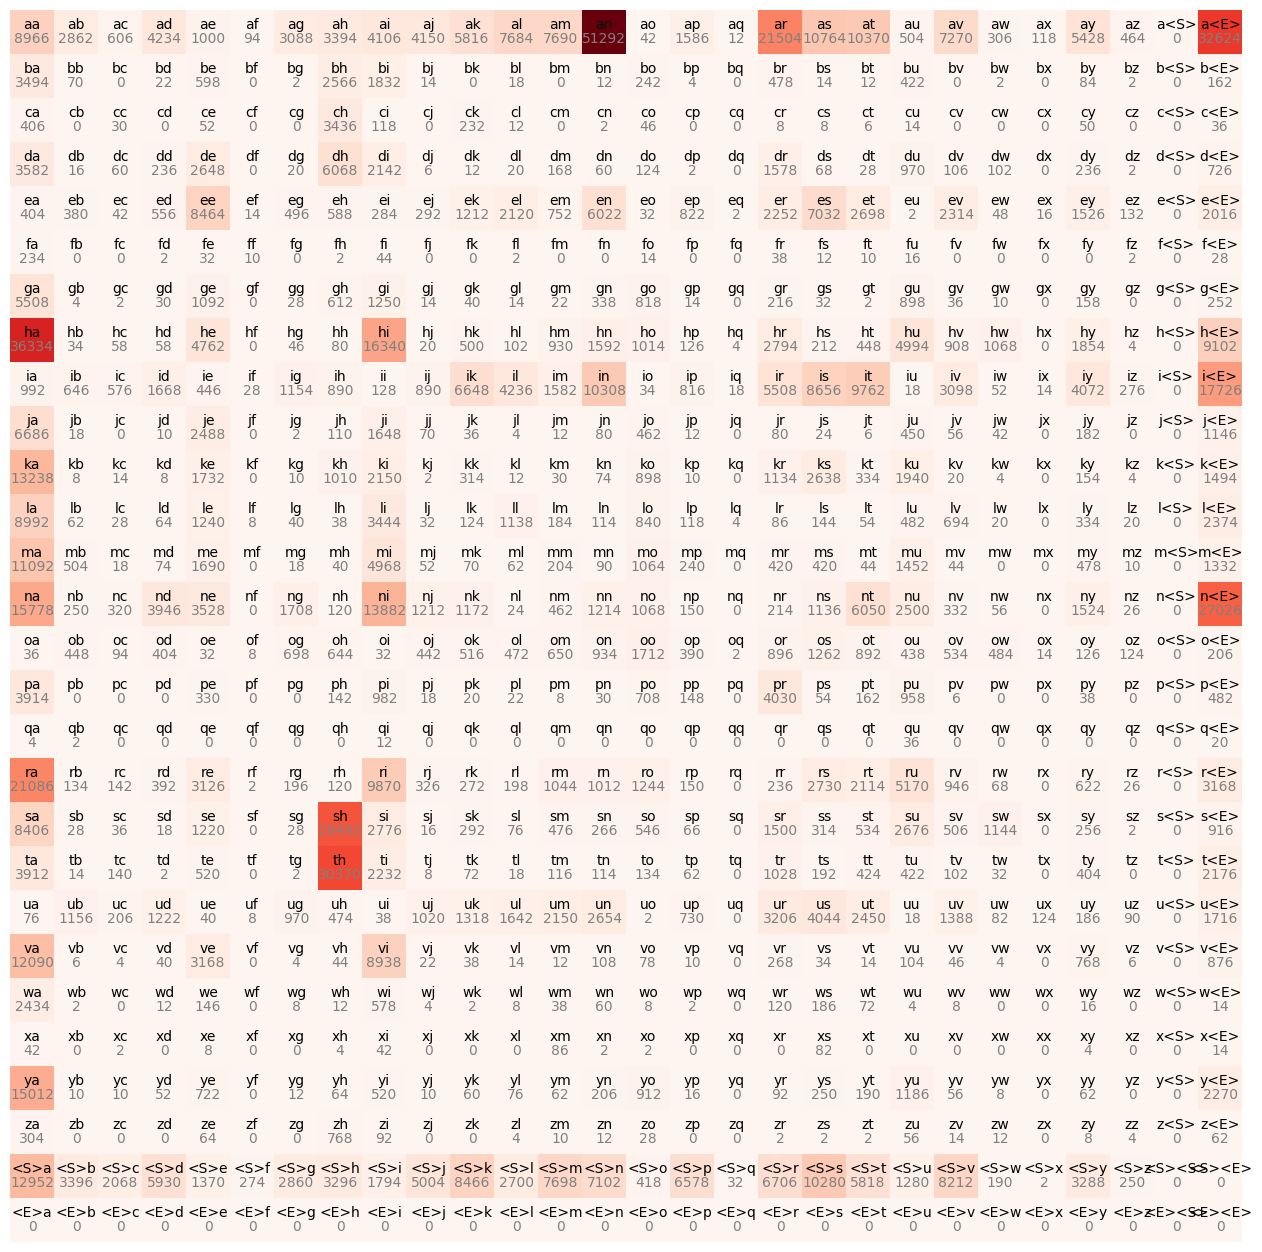

In [35]:
plt.figure(figsize=(16,16))
plt.imshow(bigramMatrix, cmap='Reds')
for i in range(28):
    for j in range(28):
        bigram = itos[i] + itos[j]
        plt.text(j, i, bigram, ha="center", va="bottom", color='black')
        plt.text(j, i, bigramMatrix[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

We see that there are two bad rows...
1. Characters cannot come to prediction after it ends
2. Characters cannot come to starting position after it has already started

So let's fix that...
And also, just to make things a little nicer, let's move our starting and ending tokens to the beginning of the mapping...
Also there is no need to bloat memory to take two different tokens, we can simply take a '.' to denote the start and end of tokens...

We will remap the lookup tables

In [37]:
# Remember we need our starting and ending tokens as well in these mappings,
characters = sorted(list(set(''.join(words)))) # Gives us all the characters in the english alphabet, hopefully our dataset has all of them
stoi = {s:i+1 for i,s in enumerate(characters)} # Enumerate returns the tuples of number and string, which can then be mapped to string:index
# We manually add these tokens for convenience
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # After we have the string:index mapping, we can easily iterate over their items to map index:string
print("Characters:",characters)
print("STOI:",stoi)
print("ITOS",itos)

Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
STOI: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
ITOS {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [41]:
# 27x27 is required because we include 26 english alphabets along with '.' token
bigramMatrix = torch.zeros((27,27), dtype=torch.int32)

In [42]:
bigramFrequency = {}
for word in words:
    word = ['.'] + list(word) + ['.']
    for character1, character2 in zip(word, word[1:]):
        # We take the indexes based on the lookup tables
        index1 = stoi[character1]
        index2 = stoi[character2]
        bigramMatrix[index1][index2] += 1

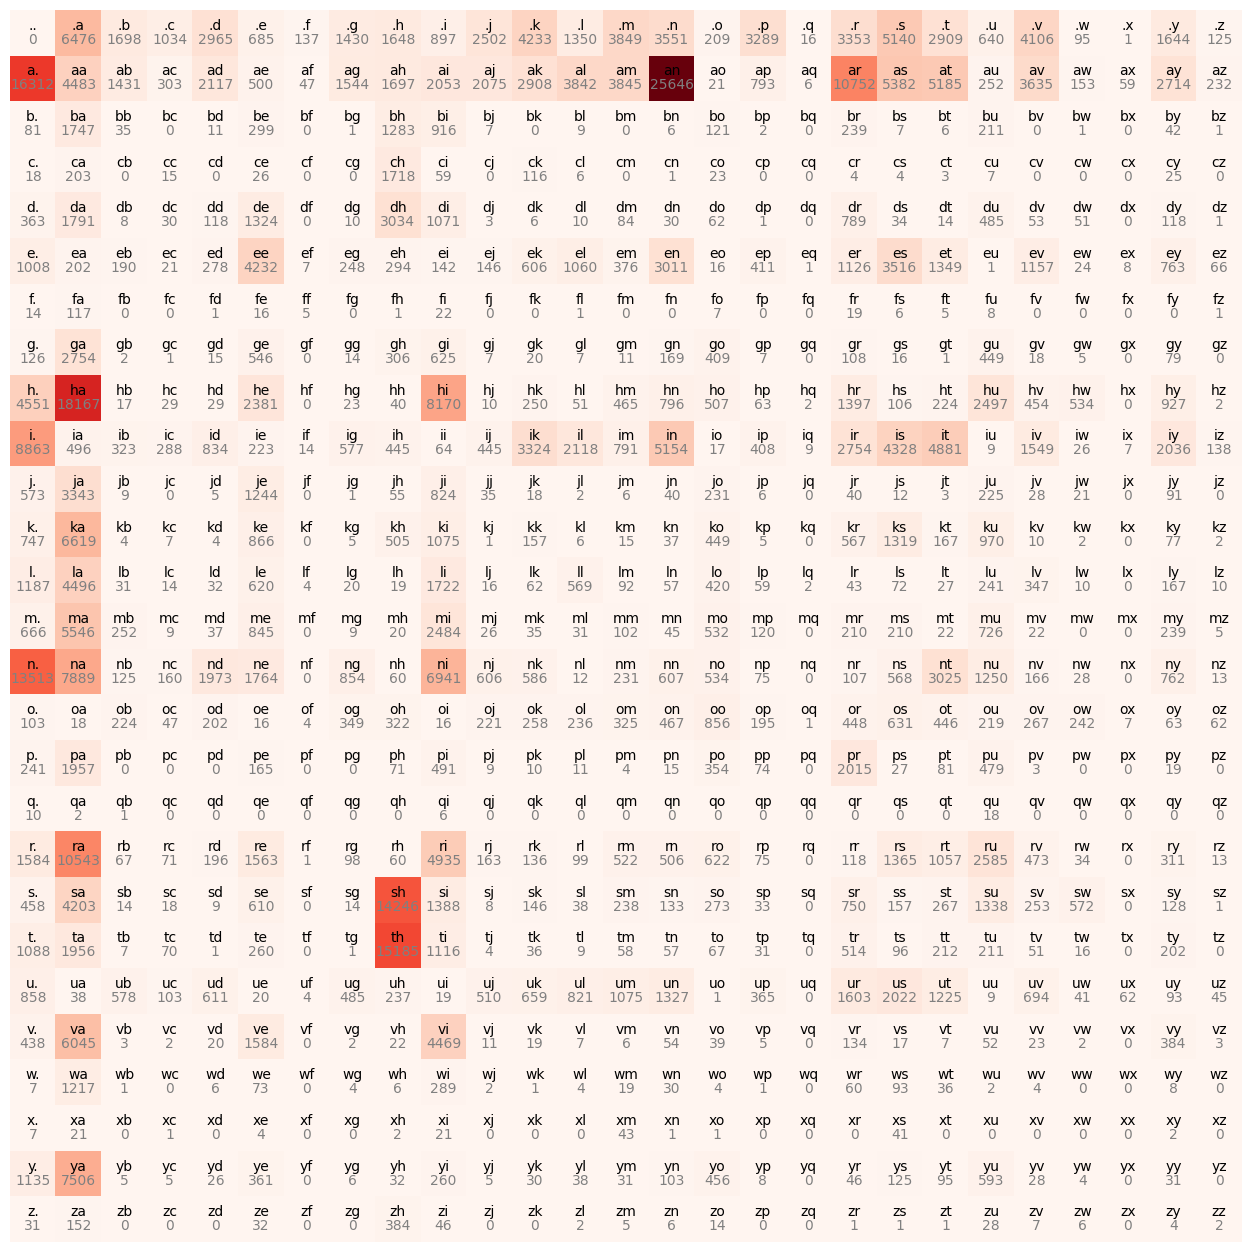

In [43]:
plt.figure(figsize=(16,16))
plt.imshow(bigramMatrix, cmap='Reds')
for i in range(27):
    for j in range(27):
        bigram = itos[i] + itos[j]
        plt.text(j, i, bigram, ha="center", va="bottom", color='black')
        plt.text(j, i, bigramMatrix[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');